In [67]:
tag='condition5'

# modules and functions
import pandas as pd
import numpy as np
from tqdm import tqdm
import pdb
import matplotlib.pyplot as plt
import itertools
from scipy import stats

def loadNpInDf(fileName):
    main_dir='/gpfs/milgram/project/turk-browne/projects/rtSynth_rt/FilterTesting/testMiniclass/'
    return np.load(main_dir+fileName+'.npy')

def preloadDfnumpy(testEvidence,List=['AC_A_evidence','AD_A_evidence','AC_B_evidence','AD_B_evidence','A_evidence_forATrials','A_evidence_forBTrials']):
    # this function convert the dataframe cell numpy array into real numpy array, was a string pointing to a file
    import warnings
    warnings.filterwarnings("ignore")
    for i in range(len(testEvidence)):
        for L in List:
            testEvidence[L].iloc[i]=loadNpInDf(testEvidence[L].iloc[i])
    warnings.filterwarnings("default")
    return testEvidence

def _and_(L):
    if len(L)==2:
        return np.logical_and(L[0],L[1])
    else:
        return np.logical_and(L[0],_and_(L[1:]))

def resample(L):
    L=np.asarray(L).reshape(-1)
    sample_mean=[]
    for iter in range(10000):
        resampleID=np.random.choice(L.shape[0], L.shape[0], replace=True)
        resample_acc=L[resampleID]
        sample_mean.append(np.nanmean(resample_acc))
    sample_mean=np.asarray(sample_mean)
    m = np.nanmean(sample_mean,axis=0)
    upper=np.percentile(sample_mean, 97.5, axis=0)
    lower=np.percentile(sample_mean, 2.5, axis=0)
    return m,m-lower,upper-m

def barplot_annotate_brackets(num1, num2, data, center, height,yerr=None, dh=.05, barh=.05, fs=None, maxasterix=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        text = ''
        p = .05

        while data < p:
            if len(text)>=3:
                break
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)
    return 

def bar(LL,labels=None,title=None,pairs=None,pvalue=None):
    import matplotlib.pyplot as plt
    D=np.asarray([resample(L) for L in LL])
    m=D[:,0]
    lower=D[:,1]
    upper=D[:,2]
    x_pos = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(10,10))
    ax.bar(x_pos, m, yerr=[lower,upper], align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('object evidence')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels)
    ax.set_title(title)
    ax.yaxis.grid(True)
    # plt.tight_layout()
    plt.xticks(rotation=30,ha='right')
    if pairs!=None:
        for pair in pairs:
            barplot_annotate_brackets(pair[0], pair[1], pvalue[pair], x_pos, m)
            m[pair[0]]+=0.1
            m[pair[1]]+=0.1
    plt.show()
    return m,lower,upper,ax

def assertKeys(t0,t1,keys=['testRun','targetAxis','obj','otherObj']):
    # this function compare the given keys of the given two df and return true if they are exactly the same
    for key in keys:
        if not np.all(np.asarray(t1[key])==np.asarray(t0[key])):
            return False
    return True

def concatArrayArray(c): #[array[],array[]]
    ct=[]
    List=[list(j) for j in c] # transform [array[],array[]] to [list[],list[]]
    for i in range(len(c)):
        ct=ct+List[i] # concatenate List
    return ct

# load saved results
accuracyContainer=[]
testEvidence=[]
for include in tqdm([0.1,0.3,0.6,0.9,1]):
    for roi in ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']:
        for filterType in ['noFilter','highPassRealTime','highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']:
            for testRun in [1,2,3,4,5,6]:
                # if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
                model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/{tag}/'
                # else:
                #     model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{np.float(include)}/{roi}/{filterType}/{testRun}/'
                try:
                    accuracyContainer.append(pd.read_csv(f"{model_folder}accuracy.csv"))
                    testEvidence.append(pd.read_csv(f'{model_folder}testEvidence.csv'))
                except:
                    pass
accuracyContainer=pd.concat(accuracyContainer, ignore_index=True)
testEvidence=pd.concat(testEvidence, ignore_index=True)


global filterTypes,subjects,ROIs
filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']
subjects=np.unique(accuracyContainer['sub'])
ROIs=['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo']


100%|██████████| 5/5 [00:30<00:00,  6.14s/it]


In [58]:
# np.unique(testEvidence['A'])
testEvidence['A']

0          bed
1        chair
2        bench
3        table
4          bed
         ...  
44283    table
44284      bed
44285    chair
44286    bench
44287    table
Name: A, Length: 44288, dtype: object

len of a= [15360, 15360, 0, 15360, 15360, 0, 15360, 15360, 0, 15360, 15360, 0]
noFilter highPassRealTime p=1.2819848791403744e-06
noFilter highPassBetweenRuns p=0.9058685770471023
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=1.1371017062977638e-05
highPassRealTime highPassBetweenRuns p=9.757494357037818e-07
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.42777410742879185
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=1.1533057566975781e-05


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


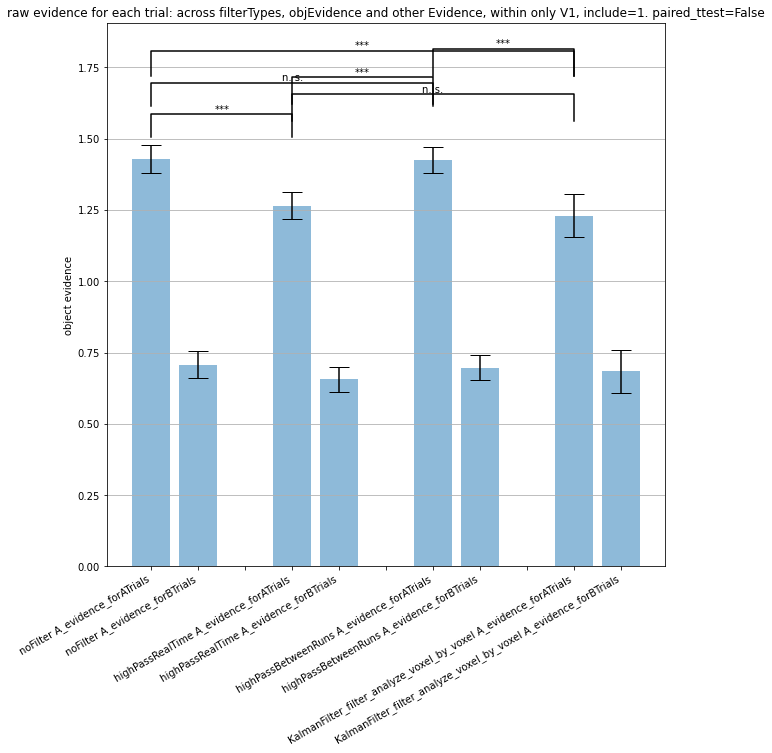

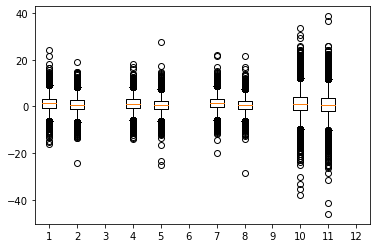

In [37]:


def evidenceAcrossFiltertypes(ROI="V1",paired_ttest=False):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 1440*32=46080 numbers (say we have 32 subjects), each number is raw value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.asarray(list(t['A_evidence_forATrials'])).reshape(-1)) #conbine the data together
            d.append(np.asarray(list(t['A_evidence_forBTrials'])).reshape(-1))

        a.append(concatArrayArray(c))
        a.append(concatArrayArray(d))
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a=',[len(i) for i in a])
    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        if paired_ttest==True:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
            pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        else:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_ind(a[i*3],a[j*3])[1]}")
            pvalue[(i*3,j*3)]=stats.ttest_ind(a[i*3],a[j*3])[1]

        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'raw evidence for each trial: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1. paired_ttest={paired_ttest}',pairs=pairs,pvalue=pvalue)

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(1):
    evidenceAcrossFiltertypes(ROI=ROIs[i])

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=1.2102386707515e-06
noFilter highPassBetweenRuns p=0.6797267723696301
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=2.4506505342835894e-05
highPassRealTime highPassBetweenRuns p=5.294629658225577e-07
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.4232548476971083
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=2.1347222791759407e-05


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


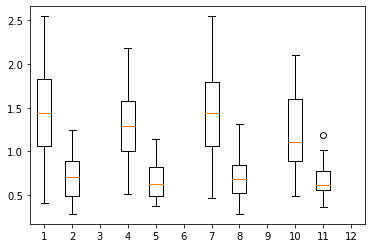

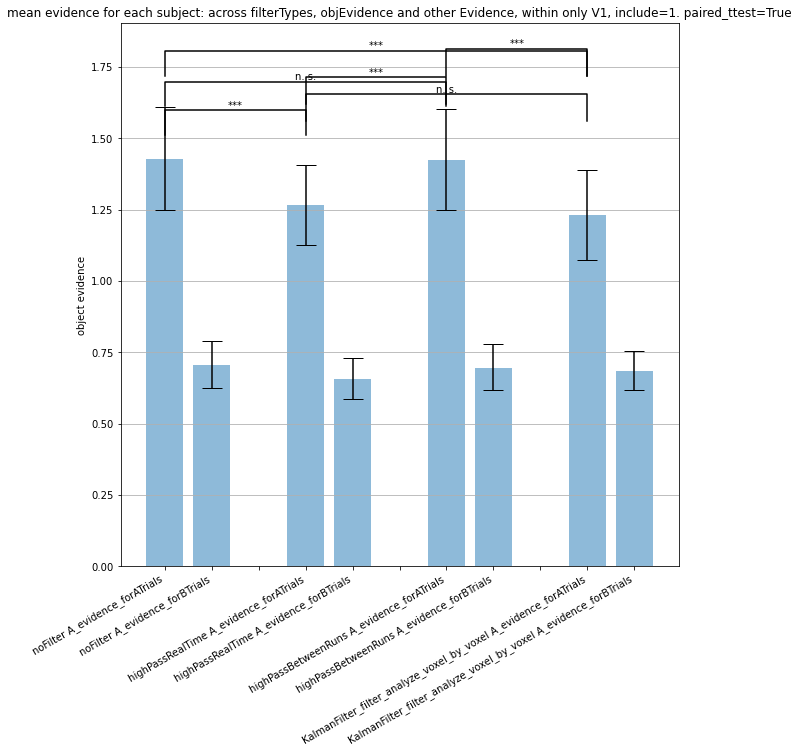

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=0.003936036033823339
noFilter highPassBetweenRuns p=0.6849850686160351
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=1.5140465268106684e-06
highPassRealTime highPassBetweenRuns p=0.004043554695218932
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=9.529487694331857e-06
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=2.1161941725807967e-06


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


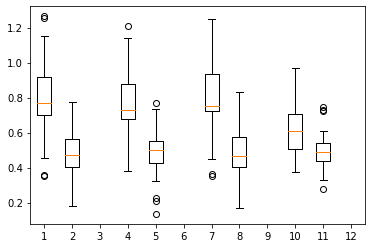

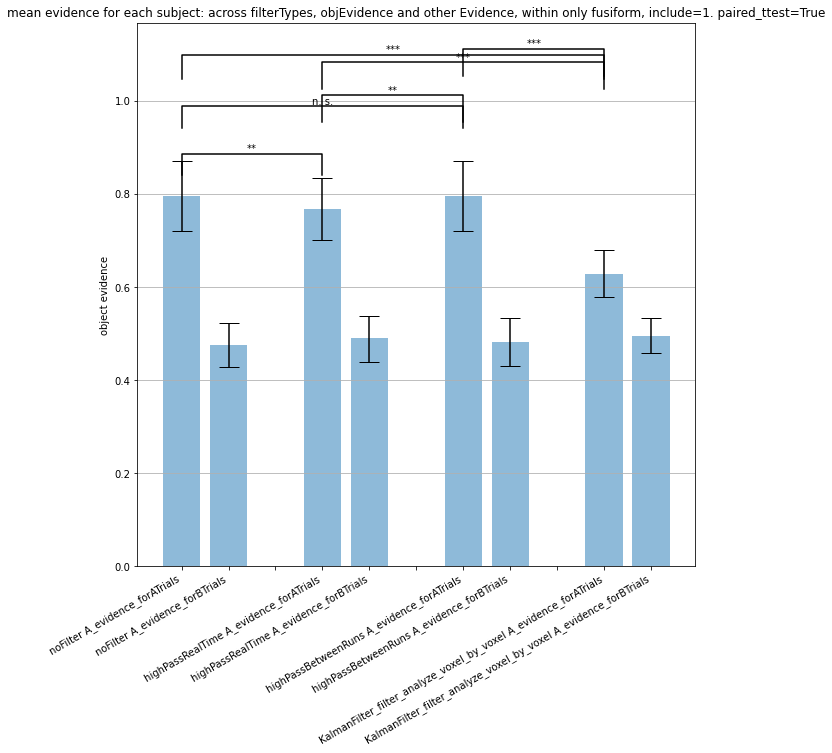

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=0.7613306835249797
noFilter highPassBetweenRuns p=0.7649589656866036
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.27398182038155205
highPassRealTime highPassBetweenRuns p=0.5652834016526398
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.37850005359270444
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.27201464608790854


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


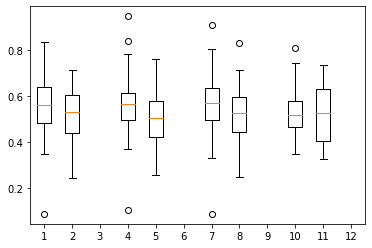

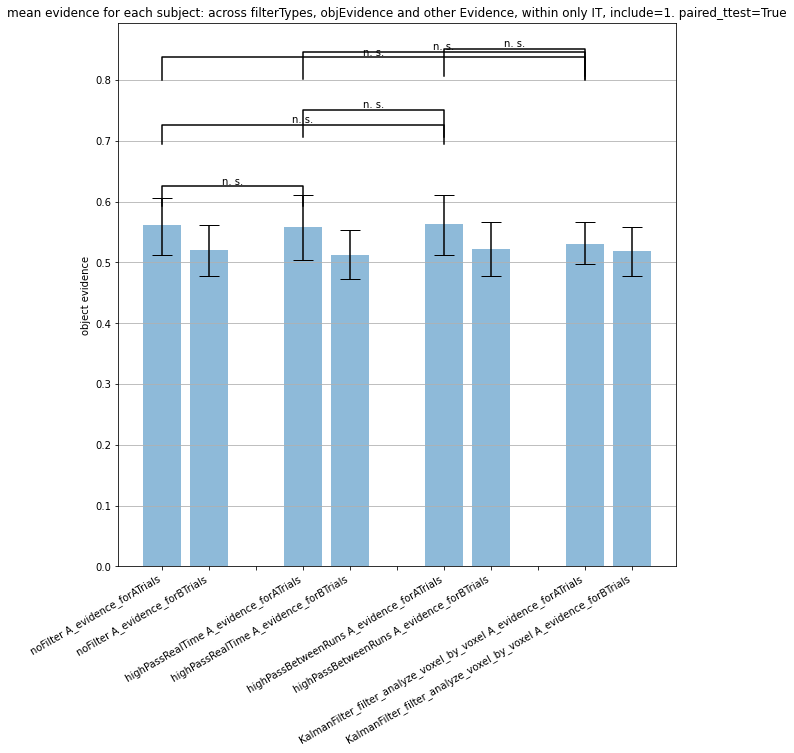

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=0.00048615438627460733
noFilter highPassBetweenRuns p=0.1824558389151226
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=5.147603344203345e-06
highPassRealTime highPassBetweenRuns p=0.000340101543276347
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.00045669046111453533
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=5.861554778923067e-06


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


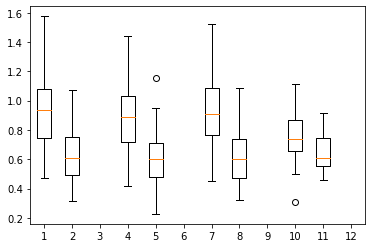

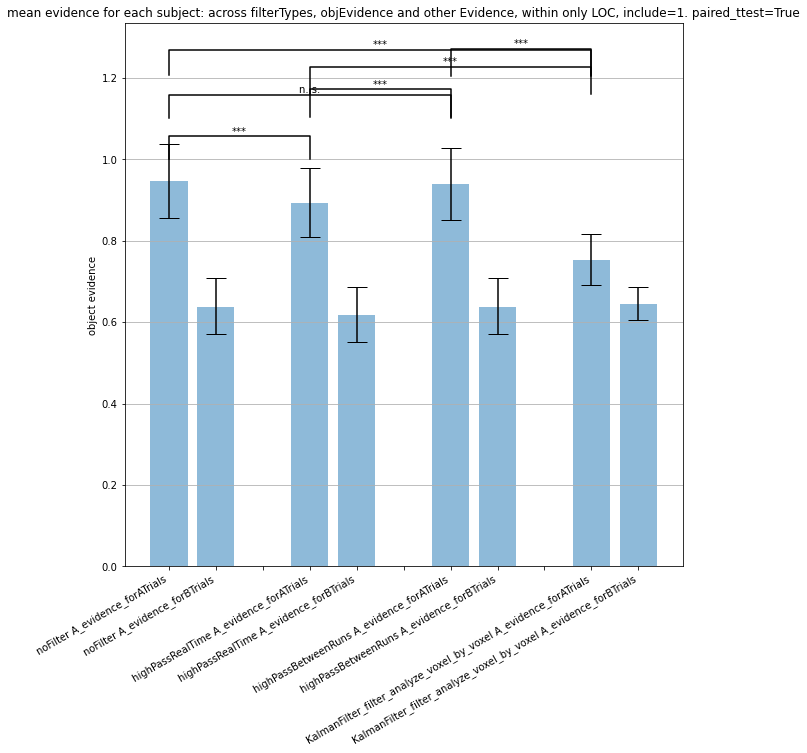

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=2.6679383313632514e-07
noFilter highPassBetweenRuns p=0.06596236441102642
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=5.1765888231191015e-05
highPassRealTime highPassBetweenRuns p=1.6002757194203996e-07
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0823902910646869
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=7.380501871537845e-05


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


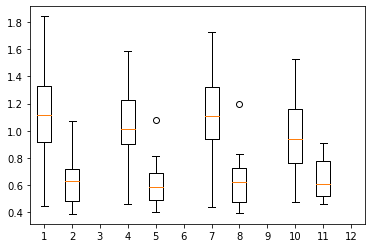

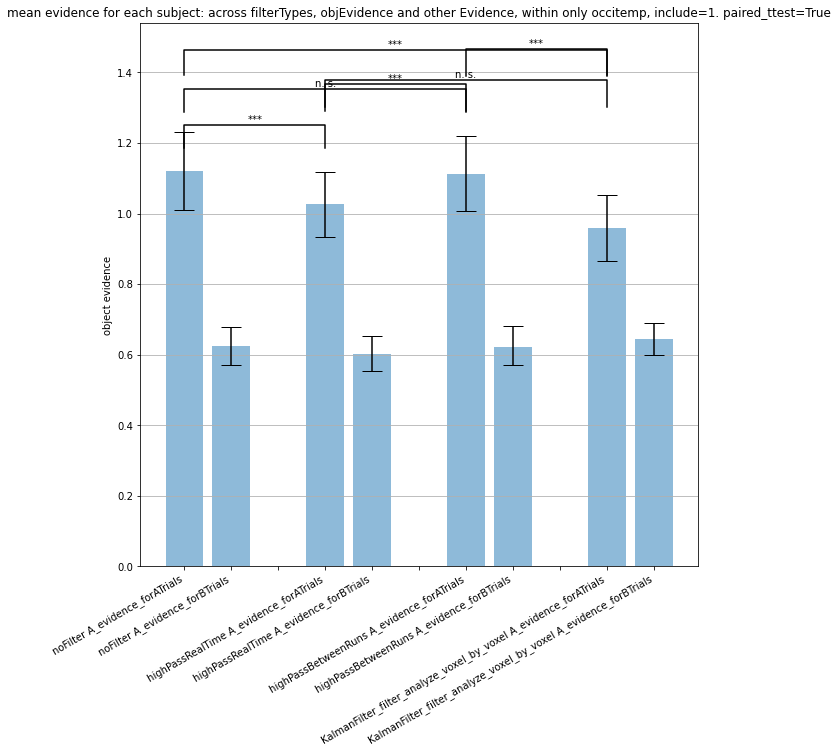

len of a =  [32, 32, 0, 32, 32, 0, 32, 32, 0, 32, 32, 0]
noFilter highPassRealTime p=0.6403638327536331
noFilter highPassBetweenRuns p=0.5270289089997473
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.24416239202815393
highPassRealTime highPassBetweenRuns p=0.4329437005962282
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.22268022898206233
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=0.3580539814749695


/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


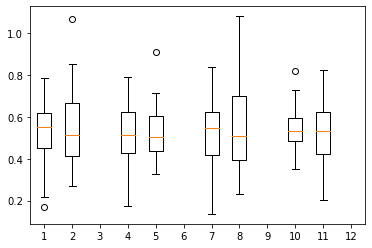

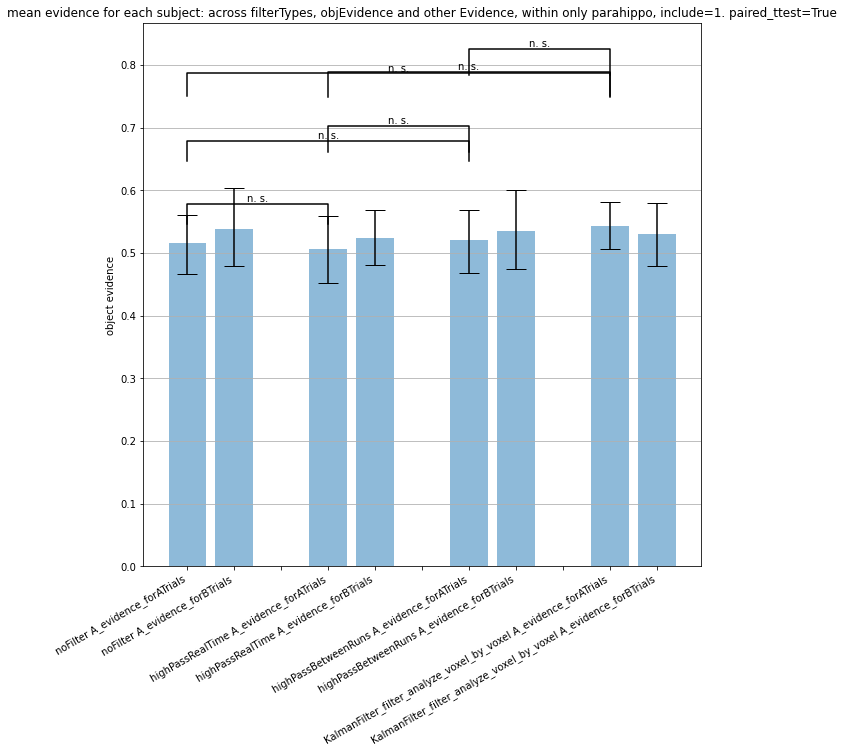

In [71]:


def evidenceAcrossFiltertypes_meanForSub(ROI="V1",paired_ttest=True):
    # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is mean value of the 'A_evidence_forATrials for noFilter' for that subject.

    # across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
    filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

    # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
    # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
    a=[]
    labels=[]
    for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
        c=[]
        d=[]

        # to get one single number for A_evidence_forATrials for each subject. 
        # you will need to extract the corresponding conditions and conbine the data together. 
        for sub in subjects:
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterTypes[i],
                testEvidence['include']==1.,
                testEvidence['sub']==sub
            ])]
            t=preloadDfnumpy(t)

            c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
            d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))

        a.append(c)
        a.append(d)
        a.append([])
        labels.append(filterTypes[i] + ' A_evidence_forATrials')
        labels.append(filterTypes[i] + ' A_evidence_forBTrials')
        labels.append('')
    print('len of a = ',[len(i) for i in a])

    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        if paired_ttest==True:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
            pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
        else:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_ind(a[i*3],a[j*3])[1]}")
            pvalue[(i*3,j*3)]=stats.ttest_ind(a[i*3],a[j*3])[1]

        pairs.append((i*3,j*3))

    bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1. paired_ttest={paired_ttest}',pairs=pairs,pvalue=pvalue)

for i in range(len(ROIs)):
    evidenceAcrossFiltertypes_meanForSub(ROI=ROIs[i])


100%|██████████| 32/32 [00:00<00:00, 75.77it/s]


noFilter highPassRealTime p=0.3725960092470254
noFilter highPassBetweenRuns p=0.6852260485732822
noFilter KalmanFilter_filter_analyze_voxel_by_voxel p=0.00012077860050594505
highPassRealTime highPassBetweenRuns p=0.1973752384574289
highPassRealTime KalmanFilter_filter_analyze_voxel_by_voxel p=0.0015606544872974898
highPassBetweenRuns KalmanFilter_filter_analyze_voxel_by_voxel p=3.534256030398765e-05


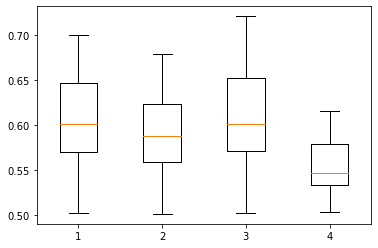

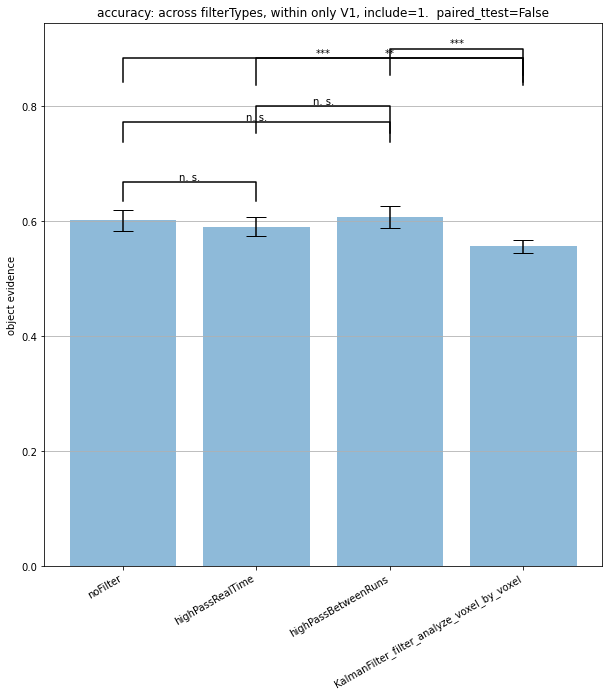

In [39]:

def accuracyAcrossFiltertype(ROI="V1",paired_ttest=False):
    # accuracy: across filterType, take subject mean, within only V1, include=1.

    # I want to construction a list whose 1st element is the accuracy for noFilter, 2nd for highpass and so on.
    # each element is 32 numbers for 32 subjects. each number is the mean accuracy for that subject.
    a=[]
    for i in range(len(filterTypes)):
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterTypes[i],
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==1.
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    # bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.')
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

    # paired t-test
    objects=np.arange(4)
    allpairs = itertools.combinations(objects,2)
    pvalue={}
    pairs=[]
    for pair in allpairs:
        i=pair[0]
        j=pair[1]
        if paired_ttest==True:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i],a[j])[1]}")
            pvalue[(i,j)]=stats.ttest_rel(a[i],a[j])[1]
        else:
            print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_ind(a[i],a[j])[1]}")
            pvalue[(i,j)]=stats.ttest_ind(a[i],a[j])[1]

        pairs.append((i,j))
    bar(a,labels=list(filterTypes),title=f'accuracy: across filterTypes, within only {ROI}, include=1.  paired_ttest={paired_ttest}',pairs=pairs,pvalue=pvalue)

for i in range(1):
    accuracyAcrossFiltertype(ROI=ROIs[i])

100%|██████████| 32/32 [00:01<00:00, 25.09it/s]


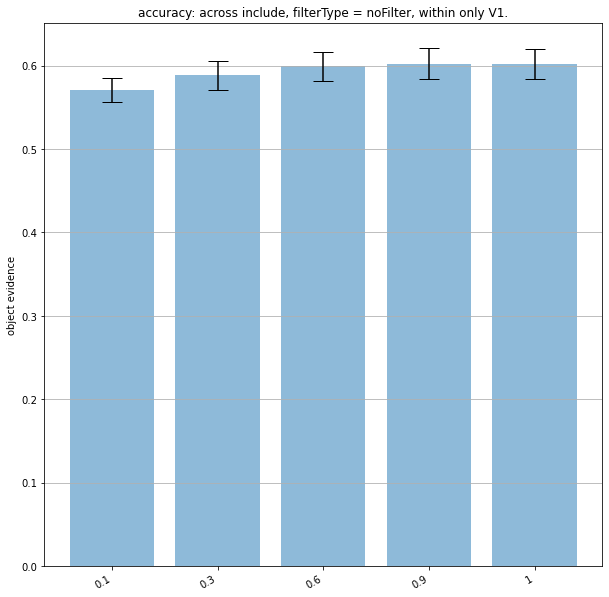

100%|██████████| 32/32 [00:01<00:00, 25.02it/s]


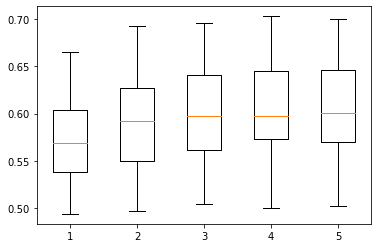

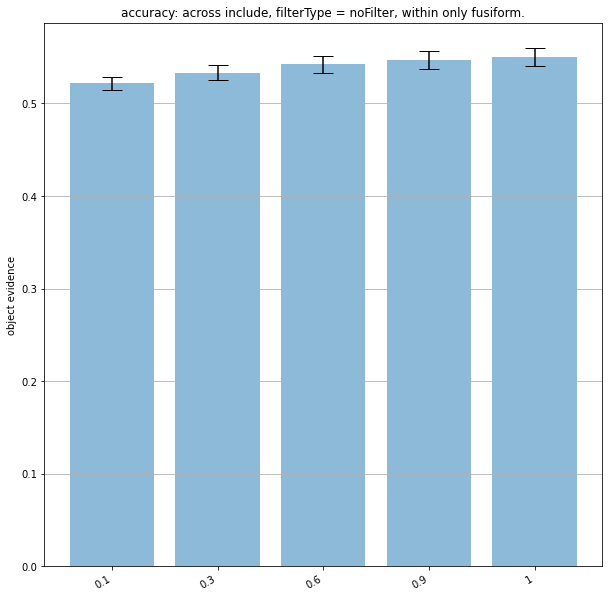

100%|██████████| 32/32 [00:01<00:00, 25.09it/s]


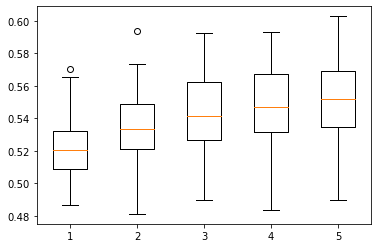

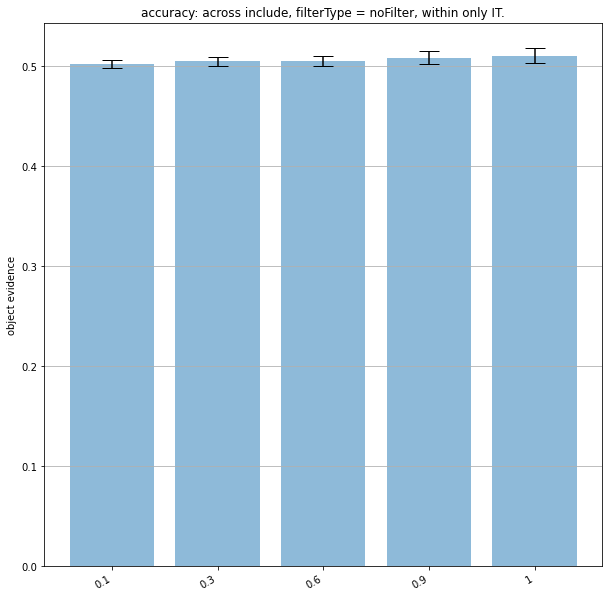

100%|██████████| 32/32 [00:01<00:00, 26.31it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


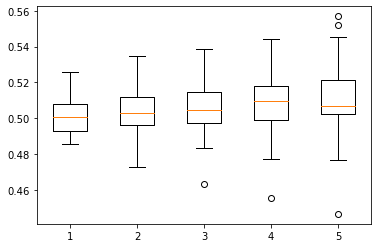

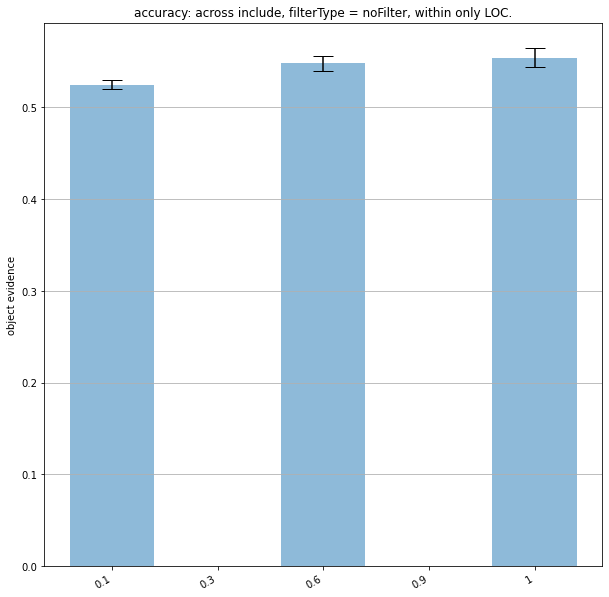

100%|██████████| 32/32 [00:01<00:00, 25.99it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


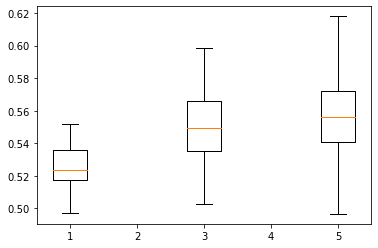

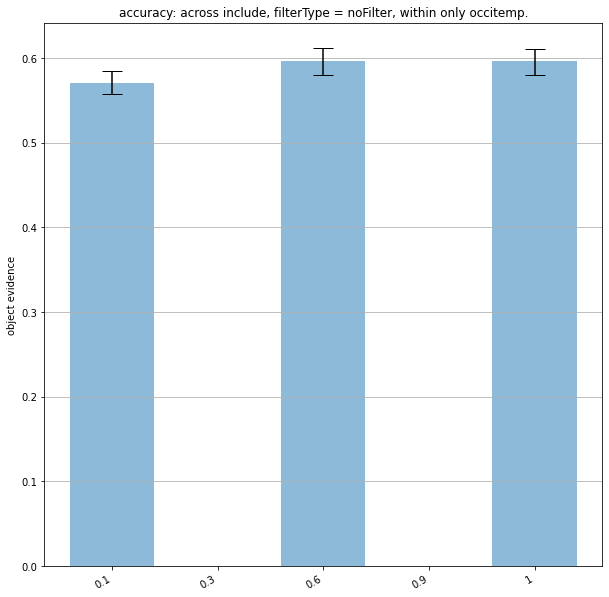

100%|██████████| 32/32 [00:01<00:00, 26.10it/s]
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


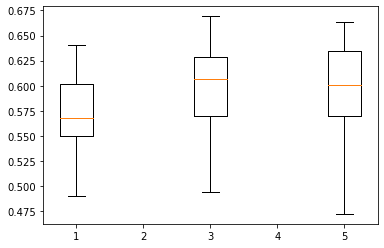

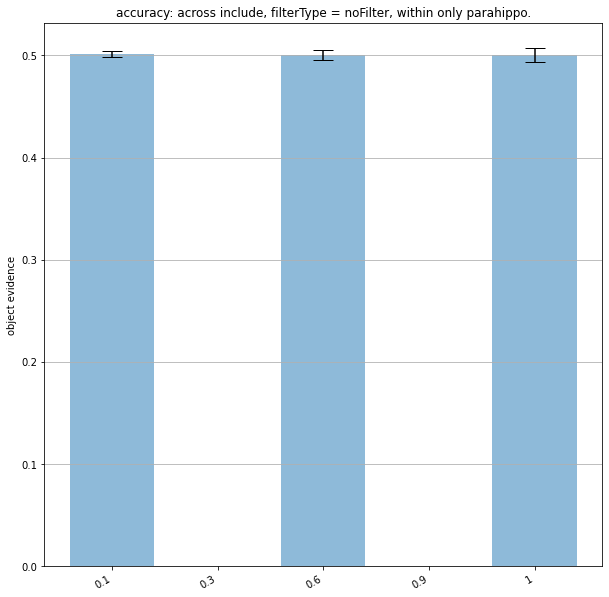

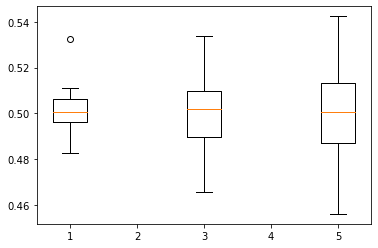

In [69]:

def accuracyIncludes(ROI="V1"):
    # compare between includes using accuracy
    # I want to construct a comparison between different includes by having includes
    includes=[0.1,0.3,0.6,0.9,1]
    filterType='noFilter'
    a=[]
    for include in includes:
        b=[]
        for sub in tqdm(subjects):
            try:
                b.append(np.mean(accuracyContainer[
                        _and_([
                            accuracyContainer['roi']==ROI, 
                            accuracyContainer['filterType']==filterType,
                            accuracyContainer['sub']==int(sub),
                            accuracyContainer['include']==np.float(include)
                        ])]['acc']))
            except:
                pass
        a.append(np.asarray(b))
    bar(a,labels=list(includes),title=f'accuracy: across include, filterType = {filterType}, within only {ROI}.')
    _=plt.figure()
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    accuracyIncludes(ROI=ROIs[i])

100%|██████████| 32/32 [00:11<00:00,  2.89it/s]


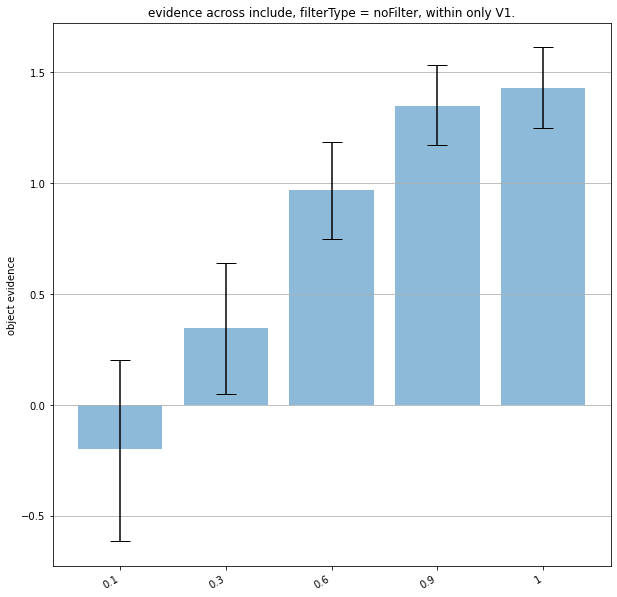

100%|██████████| 32/32 [00:03<00:00,  8.25it/s]


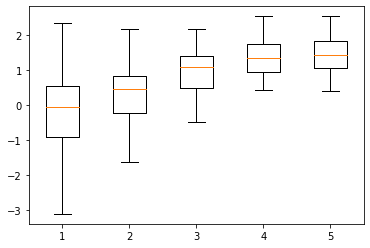

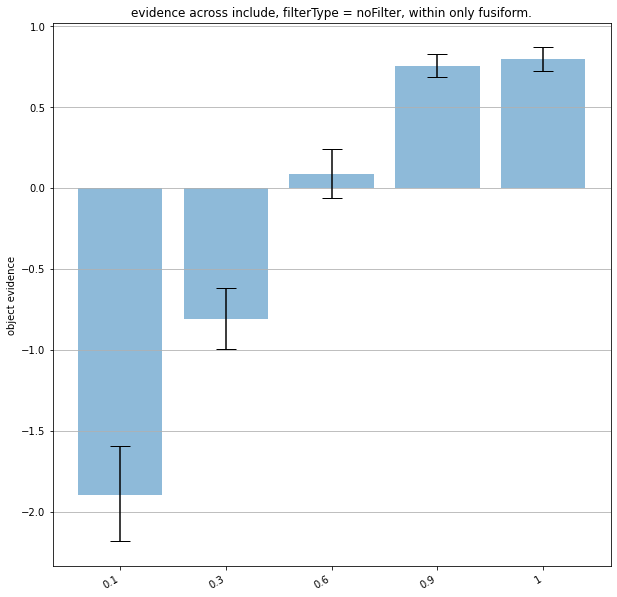

100%|██████████| 32/32 [00:03<00:00,  8.70it/s]


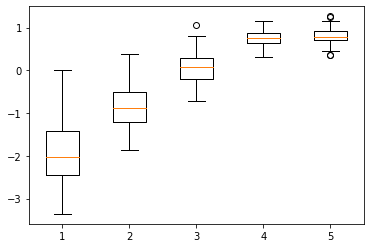

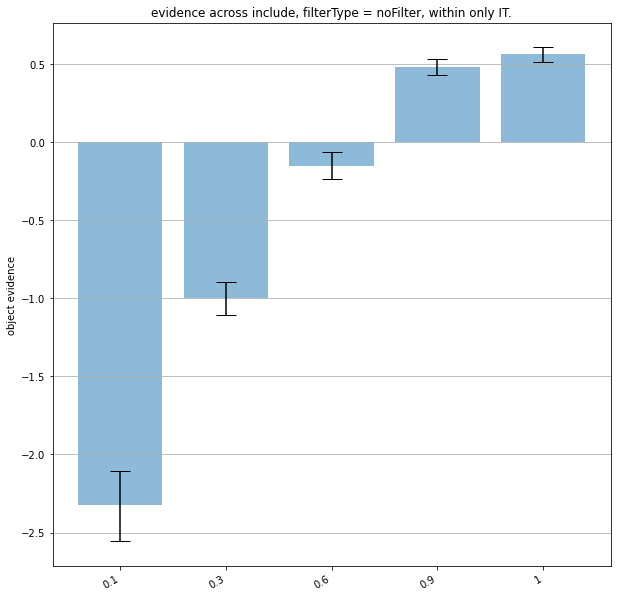

  0%|          | 0/32 [00:00<?, ?it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/pytho

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
 75%|███████▌  | 24/32 [00:00<00:00, 115.33it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten

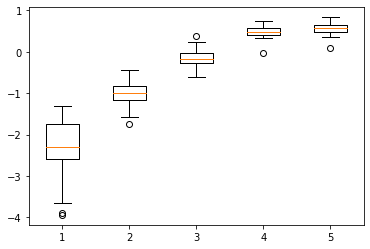

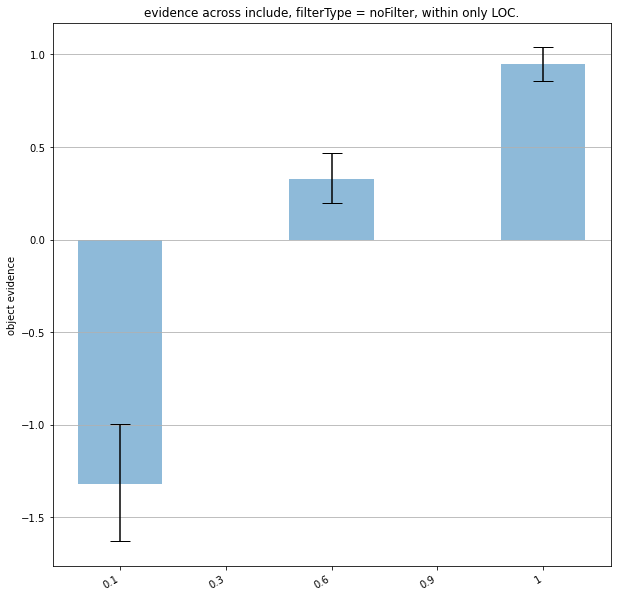

  0%|          | 0/32 [00:00<?, ?it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/pytho

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
 69%|██████▉   | 22/32 [00:00<00:00, 99.88it/s] /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten

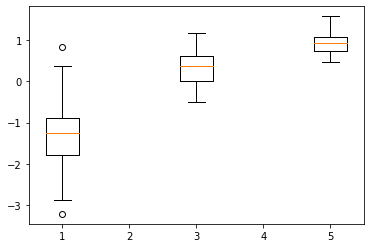

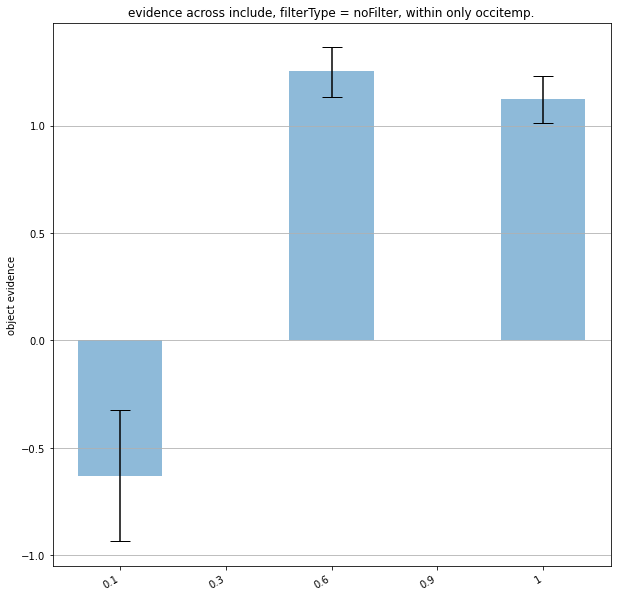

  0%|          | 0/32 [00:00<?, ?it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/pytho

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
 78%|███████▊  | 25/32 [00:00<00:00, 120.65it/s]/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten

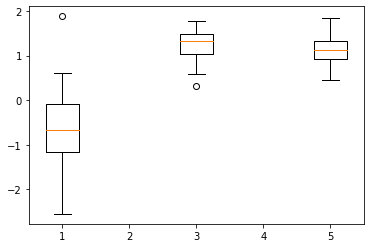

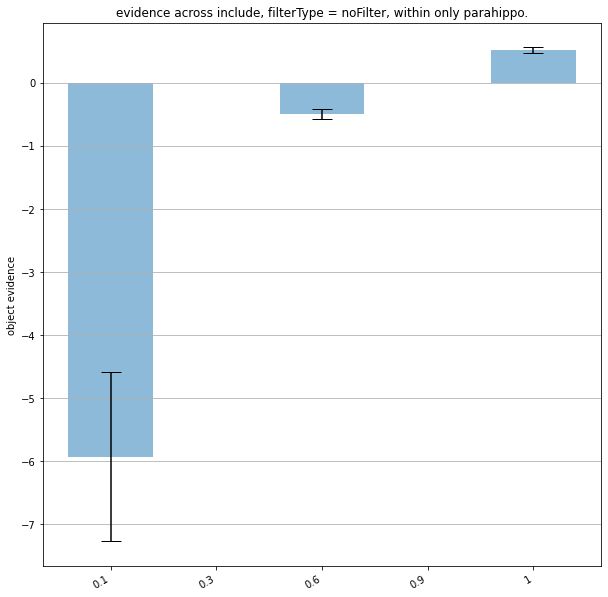

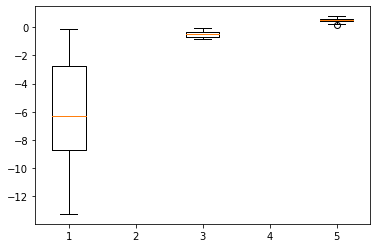

In [70]:

def evidenceIncludes(ROI="V1"): # filtering the features would often increase the performance.
    # compare between includes using evidence
    # I want to construct a comparison between different includes by having includes
    includes=[0.1,0.3,0.6,0.9,1]
    filterType='noFilter'
    a=[]
    for include in includes:
        b=[]
        for sub in tqdm(subjects):
            t=testEvidence[_and_([ #extract
                testEvidence['roi']==ROI,
                testEvidence['filterType']==filterType,
                testEvidence['include']==np.float(include),
                testEvidence['sub']==int(sub)
            ])]
            t=preloadDfnumpy(t)
            b.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials']))))
        a.append(np.asarray(b))
    bar(a,labels=list(includes),title=f'evidence across include, filterType = {filterType}, within only {ROI}.')
    _=plt.figure()
    e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
    _=plt.boxplot(e)

for i in range(len(ROIs)):
    evidenceIncludes(ROI=ROIs[i])

In [54]:
accuracyContainer[
                _and_([
                    accuracyContainer['roi']=="V1", 
                    accuracyContainer['filterType']=="noFilter",
                    accuracyContainer['sub']==subjects[0],
                    accuracyContainer['include']==np.float(0.9)
                ])]

,Unnamed: 0,sub,testRun,targetAxis,acc,filterType,roi,altobj,include,obj


In [11]:
# # hunt for bugs


# ROI="V1"
# # construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is mean value of the 'A_evidence_forATrials for noFilter' for that subject.

# # across filterType, take the difference between objEvidence and other Evidence, within only V1, include=1.
# filterTypes=['noFilter', 'highPassRealTime', 'highPassBetweenRuns','KalmanFilter_filter_analyze_voxel_by_voxel']

# # I want to construct a list where the first one is 'A_evidence_forATrials for noFilter', second is 'A_evidence_forBTrials for noFilter', third is empty, 4th is 'A_evidence_forATrials for highpass' and so on
# # for each element of the list, take 'A_evidence_forATrials for noFilter' for example. This is 32 numbers (say we have 32 subjects), each number is the mean value of the 'A_evidence_forATrials for noFilter' for that subject.
# a=[]
# labels=[]
# for i in range(len(filterTypes)): # for each filterType, each subject has one value for A_evidence_forATrials and another value for A_evidence_forBTrials
#     c=[]
#     d=[]

#     # to get one single number for A_evidence_forATrials for each subject. 
#     # you will need to extract the corresponding conditions and conbine the data together. 
#     for sub in subjects:
#         t=testEvidence[_and_([ #extract
#             testEvidence['roi']==ROI,
#             testEvidence['filterType']==filterTypes[i],
#             testEvidence['include']==1.,
#             testEvidence['sub']==sub
#         ])]
#         t=preloadDfnumpy(t)
#         pdb.set_trace()
#         c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
#         d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))
        

#     a.append(c)
#     a.append(d)
#     a.append([])
#     labels.append(filterTypes[i] + ' A_evidence_forATrials')
#     labels.append(filterTypes[i] + ' A_evidence_forBTrials')
#     labels.append('')
# print('len of a = ',[len(i) for i in a])

# e=[np.asarray(a[i])[~np.isnan(np.asarray(a[i]))] for i in range(len(a))]
# _=plt.boxplot(e)

# # paired t-test
# objects=np.arange(4)
# allpairs = itertools.combinations(objects,2)
# pvalue={}
# pairs=[]
# for pair in allpairs:
#     i=pair[0]
#     j=pair[1]
#     print(f"{filterTypes[i]} {filterTypes[j]} p={stats.ttest_rel(a[i*3],a[j*3])[1]}")
#     pvalue[(i*3,j*3)]=stats.ttest_rel(a[i*3],a[j*3])[1]
#     pairs.append((i*3,j*3))

# bar(a,labels=labels,title=f'mean evidence for each subject: across filterTypes, objEvidence and other Evidence, within only {ROI}, include=1.',pairs=pairs,pvalue=pvalue)


> <ipython-input-11-5c8a261e5a3c>(30)<module>()
     28         t=preloadDfnumpy(t)
     29         pdb.set_trace()
---> 30         c.append(np.nanmean(np.asarray(list(t['A_evidence_forATrials'])))) #conbine the data together
     31         d.append(np.nanmean(np.asarray(list(t['A_evidence_forBTrials']))))
     32 

ipdb> q


BdbQuit: 

In [16]:
data=np.load('./saveNpInDf/1605643992.4374208.npy')

In [17]:
data

array([[ 6.07294962,  4.11592727,  2.66636281, ..., -3.9881769 ,
        -6.30201245,  2.49099467],
       [-0.1931023 ,  2.22855209,  6.8910972 , ..., -1.18826889,
         2.4395841 , -1.77048752],
       [ 6.17905865,  8.15030033,  7.67283613, ...,  4.94860384,
        -2.93346714, -1.6714966 ],
       ...,
       [ 2.02704711, -3.41301726,  0.50254449, ..., -2.4322135 ,
         1.73130384,  5.80899713],
       [ 4.23387041, -0.87138063, -0.34668804, ...,  0.71467076,
         1.31027162, -2.16890789],
       [-4.04840248, -1.56684108, -0.59278735, ...,  3.66861145,
         1.31582398, -1.40807951]])

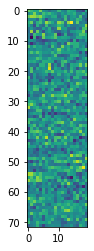

In [18]:
plt.imshow(data)

In [19]:
np.mean(data)

0.5

In [20]:
np.mean(data,axis=0)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [21]:
np.mean(data,axis=1)

array([ 0.81925323,  1.50877568,  2.38151991, -0.23435745,  2.9929526 ,
        0.22558176, -0.28129892,  0.0812811 ,  0.62091911,  0.59946567,
       -2.11387172, -0.60022099,  1.07415144,  1.133189  ,  1.12053624,
       -0.43736559,  0.71770187,  0.80417659,  0.90522462,  0.15050047,
        2.12802756,  0.27534809, -1.34572943, -0.52576086,  1.15282368,
        0.75298764,  0.29219646, -0.23331918,  2.12614085,  0.98033154,
        1.64646621, -0.34286089,  1.41369894,  0.69003721, -2.03983979,
       -0.43866267,  1.59717529,  0.76966599,  1.19349131,  0.51119618,
        2.4270423 ,  0.21913783,  1.16970931, -0.55168314,  0.84111681,
        0.45450785, -1.76815911, -0.86320062,  0.91263961,  1.55530967,
        1.44495136, -0.42782976,  1.83280291,  0.37252008,  1.12865235,
        0.72474555,  1.89071354, -0.13738516, -2.22351645, -1.0736037 ,
       -0.26545039,  0.29192013,  0.91531815,  0.54267821,  1.47688724,
        0.66540166,  1.57102418,  1.02253458,  0.10634852,  0.74

In [30]:
np.mean(data[:,0])

0.4999999999999999

In [31]:
data[:,0].shape

(72,)

In [25]:
data

array([[ 6.07294962,  4.11592727,  2.66636281, ..., -3.9881769 ,
        -6.30201245,  2.49099467],
       [-0.1931023 ,  2.22855209,  6.8910972 , ..., -1.18826889,
         2.4395841 , -1.77048752],
       [ 6.17905865,  8.15030033,  7.67283613, ...,  4.94860384,
        -2.93346714, -1.6714966 ],
       ...,
       [ 2.02704711, -3.41301726,  0.50254449, ..., -2.4322135 ,
         1.73130384,  5.80899713],
       [ 4.23387041, -0.87138063, -0.34668804, ...,  0.71467076,
         1.31027162, -2.16890789],
       [-4.04840248, -1.56684108, -0.59278735, ...,  3.66861145,
         1.31582398, -1.40807951]])

In [36]:
t=testEvidence[_and_([ #extract
            testEvidence['roi']=="V1",
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==subjects[0]
        ])]
t=preloadDfnumpy(t)
data1=np.asarray(list(t['AC_B_evidence']))
print(data1.shape)
print(np.mean(data1))


t=testEvidence[_and_([ #extract
            testEvidence['roi']=="V1",
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==subjects[0]
        ])]
t=preloadDfnumpy(t)
data2=np.asarray(list(t['AD_B_evidence']))
print(data2.shape)
print(np.mean(data2))

(72, 20)
0.2311613518918914
(72, 20)
0.7688386481081086


In [37]:
data1

array([[ 4.10516999, -5.10904602,  5.61254046, ..., -2.67530733,
        -5.30931967,  4.62433569],
       [ 1.59244269,  2.40590896,  6.14937501, ..., -3.21808272,
         4.03010997,  2.66959452],
       [ 5.36612491,  3.77204742,  7.03387125, ...,  6.91259028,
        -3.54547903, -1.84660459],
       ...,
       [ 2.64745672, -0.85237838,  1.61215784, ..., -2.63116034,
         3.34652069,  4.13197021],
       [ 5.13022409, -4.08677865, -0.40979472, ...,  0.62177922,
         0.12091725, -4.3482093 ],
       [-6.16444661, -1.67530047, -1.56648322, ...,  7.03748404,
         2.44678393, -3.88156248]])

In [40]:
data2

array([[ 8.04072925e+00,  1.33409006e+01, -2.79814842e-01, ...,
        -5.30104647e+00, -7.29470523e+00,  3.57653644e-01],
       [-1.97864728e+00,  2.05119523e+00,  7.63281939e+00, ...,
         8.41544946e-01,  8.49058221e-01, -6.21056955e+00],
       [ 6.99199239e+00,  1.25285532e+01,  8.31180101e+00, ...,
         2.98461740e+00, -2.32145525e+00, -1.49638862e+00],
       ...,
       [ 1.40663750e+00, -5.97365614e+00, -6.07068850e-01, ...,
        -2.23326666e+00,  1.16086993e-01,  7.48602405e+00],
       [ 3.33751673e+00,  2.34401738e+00, -2.83581361e-01, ...,
         8.07562308e-01,  2.49962598e+00,  1.03935319e-02],
       [-1.93235835e+00, -1.45838170e+00,  3.80908512e-01, ...,
         2.99738857e-01,  1.84864042e-01,  1.06540346e+00]])

In [43]:
np.mean(data1)+np.mean(data2)

1.0

In [45]:
np.mean(data1+data2,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [46]:
data1+data2

array([[ 12.14589924,   8.23185455,   5.33272562, ...,  -7.97635381,
        -12.6040249 ,   4.98198933],
       [ -0.38620459,   4.45710419,  13.7821944 , ...,  -2.37653777,
          4.87916819,  -3.54097503],
       [ 12.3581173 ,  16.30060067,  15.34567226, ...,   9.89720768,
         -5.86693428,  -3.34299321],
       ...,
       [  4.05409422,  -6.82603453,   1.00508899, ...,  -4.864427  ,
          3.46260768,  11.61799426],
       [  8.46774081,  -1.74276126,  -0.69337608, ...,   1.42934153,
          2.62054323,  -4.33781577],
       [ -8.09680496,  -3.13368216,  -1.18557471, ...,   7.3372229 ,
          2.63164797,  -2.81615902]])

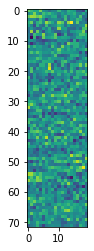

In [47]:
plt.imshow(data1+data2)

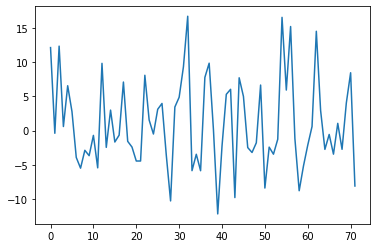

In [51]:
data=data1+data2
plt.plot(data[:,0])

In [53]:
np.mean(data1[:,0])

0.1751431468366628

In [54]:
t

,Unnamed: 0,sub,testRun,targetAxis,obj,obj_evidence,otherObj_evidence,filterType,roi,AC_A_evidence,AC_B_evidence,AD_A_evidence,AD_B_evidence,A_evidence_forATrials,A_evidence_forBTrials,A_evidence_forBTrials_minus_A_evidence_forBTrials,include,otherObj
76800,0,110171,1,"('bed', 'bench')",bed,NaN,NaN,noFilter,V1,"[1.4418466361202489, 5.328673040033227, -1.259...","[4.1051699880848265, -5.109046023894983, 5.612...","[7.88160680614107, 8.497629993376655, 6.218910...","[8.040729249042526, 13.340900573767223, -0.279...","[4.661726721130659, 6.913151516704941, 2.47946...","[6.072949618563676, 4.11592727493612, 2.666362...",1.553384,1.0,bench
76801,1,110171,1,"('bed', 'bench')",bench,NaN,NaN,noFilter,V1,"[2.6328716467069, -0.2789553937554994, 9.96251...","[1.592442686300051, 2.405908959582166, 6.14937...","[-1.9071300055240425, 6.411432702303663, 1.832...","[-1.9786472799025896, 2.051195228567768, 7.632...","[0.36287082059142883, 3.066238654274082, 5.897...","[-0.19310229680126934, 2.228552094074967, 6.89...",0.750375,1.0,bed
76802,2,110171,1,"('bed', 'chair')",bed,NaN,NaN,noFilter,V1,"[4.94344801058114, 4.589540562206983, -6.59807...","[5.36612491266607, 3.772047422339315, 7.033871...","[7.88160680614107, 8.497629993376655, 6.218910...","[6.99199239043577, 12.528553244653361, 8.31180...","[6.412527408361105, 6.543585277791819, -0.1895...","[6.179058651550919, 8.150300333496338, 7.67283...",-1.054647,1.0,chair
76803,3,110171,1,"('bed', 'chair')",chair,NaN,NaN,noFilter,V1,"[5.099375153487267, 2.7181218574366772, 7.8458...","[-0.5924426863000509, -1.405908959582166, -5.1...","[5.951835559176855, 10.954195102930521, 6.5344...","[1.1950133460590087, 1.4216085283278395, 5.290...","[5.525605356332061, 6.836158480183599, 7.19013...","[0.30128532987947887, 0.007849784372836677, 0....",3.730058,1.0,bed
76804,4,110171,1,"('bed', 'table')",bed,NaN,NaN,noFilter,V1,"[4.94344801058114, 4.589540562206983, -6.59807...","[5.640439150014912, 9.943720170936661, -4.4819...","[1.4418466361202489, 5.328673040033227, -1.259...","[0.9284512118818489, 2.6974677904987576, -0.22...","[3.1926473233506942, 4.959106801120105, -3.929...","[3.2844451809483806, 6.320593980717709, -2.353...",-0.730315,1.0,table
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78727,7,110171,6,"('bench', 'chair')",chair,NaN,NaN,noFilter,V1,"[-0.279762802564037, -0.4988742309330016, -0.4...","[1.4733534996235134, 5.022455327860165, 2.1001...","[6.49736879955371, 1.5897737438832, 2.70657511...","[-0.40663749767850166, 6.973656143782312, 1.60...","[3.1088029984948364, 0.5454497564750992, 1.142...","[0.5333580009725059, 5.9980557358212385, 1.853...",2.196752,1.0,bench
78728,8,110171,6,"('bench', 'table')",bench,NaN,NaN,noFilter,V1,"[1.180608111210278, -1.026713151877182, 7.4031...","[-0.3914086188343419, -4.886774920411843, 2.25...","[2.0910361251823635, -6.525265702954572, 4.852...","[-2.3375167276821767, -1.3440173837139366, 1.2...","[1.6358221181963208, -3.775989427415877, 6.128...","[-1.3644626732582592, -3.11539615206289, 1.770...",1.288957,1.0,table
78729,9,110171,6,"('bench', 'table')",table,NaN,NaN,noFilter,V1,"[4.135466183358306, -5.0375032439799785, 2.895...","[2.6474567181248196, -0.8523783816612249, 1.61...","[-1.8025723696250489, -0.9188842595534737, 2.1...","[1.4066374976785017, -5.973656143782312, -0.60...","[1.1664469068666288, -2.9781937517667263, 2.50...","[2.0270471079016605, -3.4130172627217688, 0.50...",0.231648,1.0,bench
78730,10,110171,6,"('chair', 'table')",chair,NaN,NaN,noFilter,V1,"[-0.279762802564037, -0.4988742309330016, -0.4...","[5.130224085823245, -4.086778647944281, -0.409...","[7.031036317900999, 2.416042602934267, 3.97377...","[3.3375167276821767, 2.3440173837139366, -0.28...","[3.375636757668481, 0.9585841860006327, 1.7764...","[4.233870406752711, -0.8713806321151722, -0.34...",2.333333,1.0,table


In [55]:
t=testEvidence[_and_([ #extract
            testEvidence['roi']=="V1",
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==subjects[0]
        ])]
t=preloadDfnumpy(t)
data=np.asarray(list(t['A_evidence_forBTrials']))
print(data.shape)
print(np.mean(data))


(72, 20)
0.5


In [65]:
t['A_evidence_forBTrials'].iloc[0]

array([ 6.07294962,  4.11592727,  2.66636281,  2.39171616,  6.89231817,
        0.44170446, -0.57974998, -2.59608682, -0.79057918, -0.72524969,
        4.01456862,  0.03333135, -1.10914777,  3.6378281 ,  2.15423526,
        1.34481341, -3.78068249, -3.9881769 , -6.30201245,  2.49099467])

In [66]:
t['A_evidence_forBTrials'].iloc[1]

array([-0.1931023 ,  2.22855209,  6.8910972 ,  1.64269728, -0.7637058 ,
        4.5611684 ,  2.89412072,  4.10615918,  1.97343215,  0.66232012,
       -1.41276363,  1.52293732, -0.32232982,  2.56893394,  1.82294618,
        3.38748296, -0.87525999, -1.18826889,  2.4395841 , -1.77048752])

In [64]:
np.asarray(list(t['A_evidence_forBTrials']))

array([[ 6.07294962,  4.11592727,  2.66636281, ..., -3.9881769 ,
        -6.30201245,  2.49099467],
       [-0.1931023 ,  2.22855209,  6.8910972 , ..., -1.18826889,
         2.4395841 , -1.77048752],
       [ 6.17905865,  8.15030033,  7.67283613, ...,  4.94860384,
        -2.93346714, -1.6714966 ],
       ...,
       [ 2.02704711, -3.41301726,  0.50254449, ..., -2.4322135 ,
         1.73130384,  5.80899713],
       [ 4.23387041, -0.87138063, -0.34668804, ...,  0.71467076,
         1.31027162, -2.16890789],
       [-4.04840248, -1.56684108, -0.59278735, ...,  3.66861145,
         1.31582398, -1.40807951]])

In [67]:
np.mean(np.asarray(list(t['A_evidence_forBTrials'])),axis=0)

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [2]:
t=testEvidence[_and_([ #extract
            testEvidence['roi']=="V1",
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==subjects[0],
            testEvidence['obj']=='bed',
            testEvidence['otherObj']=='chair',
        ])]
t=preloadDfnumpy(t)
data=np.asarray(list(t['A_evidence_forBTrials']))
print(data.shape)
print(np.mean(data))


NameError: name 'testEvidence' is not defined

In [76]:
t=testEvidence[_and_([ #extract
            testEvidence['roi']=="V1",
            testEvidence['filterType']==filterTypes[i],
            testEvidence['include']==1.,
            testEvidence['sub']==subjects[0],
#             testEvidence['obj']=='bed',
#             testEvidence['otherObj']=='chair',
            testEvidence['testRun']==1
    
        ])]
t=preloadDfnumpy(t)
data=np.asarray(list(t['A_evidence_forBTrials']))
print(data.shape)
print(np.mean(data))


(12, 20)
0.49999999999999994


In [79]:
def other(target):
    other_objs = [i for i in ['bed  ', 'bench', 'chair', 'table'] if i not in target]
    return other_objs
objects=['bed  ', 'bench', 'chair', 'table']

allpairs = itertools.combinations(objects,2)
for pair in allpairs: # e.g. pair=('bed', 'bench')
    # Find the control (remaining) objects for this pair
    altpair = other(pair) # altpair=('chair', 'table')

    # obj is A
    # otherObj is B
    # altpair[0] is C
    # altpair[1] is D

    for obj in pair: # obj='bed', obj is A
        # in the current target axis pair=('bed', 'bench') altpair=('chair', 'table'), display image obj='bed'
        # find the evidence for bed from the (bed chair) and (bed table) classifier

        # get the test data and seperate the test data into category obj and category other
        otherObj=[i for i in pair if i!=obj][0] # otherObj is B
        A=obj ; B=otherObj ; C=altpair[0] ; D=altpair[1]
#         print(f"A={obj} ; B={otherObj} ; C={altpair[0]} ; D={altpair[1]}")
        #print(f"ACB ADB")
        print(f"{A} {C} {B}        {A} {D} {B}")
    

bed   chair bench        bed   table bench
bench chair bed          bench table bed  
bed   bench chair        bed   table chair
chair bench bed          chair table bed  
bed   bench table        bed   chair table
table bench bed          table chair bed  
bench bed   chair        bench table chair
chair bed   bench        chair table bench
bench bed   table        bench chair table
table bed   bench        table chair bench
chair bed   table        chair bench table
table bed   chair        table bench chair


In [82]:
def other(target):
    other_objs = [i for i in ['bed  ', 'bench', 'chair', 'table'] if i not in target]
    return other_objs
objects=['bed  ', 'bench', 'chair', 'table']

# allpairs = [('bed  ', 'chair')  , ('chair', 'bed  ') , ('bench', 'table')  , ('table', 'bench')]
allpairs = [('bed  ', 'chair')  , ('bench', 'table') ]

for pair in allpairs: # e.g. pair=('bed', 'bench')

    # Find the control (remaining) objects for this pair
    altpair = other(pair) # altpair=('chair', 'table')

    # obj is A
    # otherObj is B
    # altpair[0] is C
    # altpair[1] is D

    for obj in pair: # obj='bed', obj is A
        # in the current target axis pair=('bed', 'bench') altpair=('chair', 'table'), display image obj='bed'
        # find the evidence for bed from the (bed chair) and (bed table) classifier

        # get the test data and seperate the test data into category obj and category other
        otherObj=[i for i in pair if i!=obj][0] # otherObj is B
        A=obj ; B=otherObj ; C=altpair[0] ; D=altpair[1]
#         print(f"A={obj} ; B={otherObj} ; C={altpair[0]} ; D={altpair[1]}")
        #print(f"ACB ADB")
        print(f"{A} {C} {B}        {A} {D} {B}")
    

bed   bench chair        bed   table chair
chair bench bed          chair table bed  
bench bed   table        bench chair table
table bed   bench        table chair bench


In [34]:
# This code is a copy from the recog_features.py but to deal with the output filtered
# brain data using Kalman filtering generated by Alex.

'''
The "input" of this code is 
    regressor file: recog_reg 
        which looks like three colum regressors that are used in FEAT, each object (ABCD) has a seperate regressor file?
    raw brain data: 

    where is the behavior data? at what time is each image presented? That would be the regressor file
'''

import pandas as pd
import nibabel as nib
from glob import glob
import os
from subprocess import call
import sys
import numpy as np    
import time
# sys.path.append('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten')
import ray
from pykalman import KalmanFilter
from tqdm import tqdm

ray.init(ignore_reinit_error=True)
@ray.remote(num_cpus = 0.5)
def kalman_filter_voxel(measurement):
    kf = KalmanFilter(n_dim_state = measurement.shape[1], n_dim_obs = measurement.shape[1], 
                          observation_matrices = np.eye(measurement.shape[1]),
                          observation_covariance = np.eye(measurement.shape[1]),
                          observation_offsets = np.zeros(measurement.shape[1]))
    kf = kf.em(measurement, n_iter=5,
                  em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
                            'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
                  )
    (filtered_state_means, filtered_state_covariances) = kf.filter(measurement)
    return filtered_state_means.reshape(-1)
    
def filtering(timeseries=None, filterType='highPassRealTime'): 
    '''
    filterType can be 
        highPassRealTime 
        highPassBetweenRuns 
        UnscentedKalmanFilter_filter # documentation: https://pykalman.github.io/
        UnscentedKalmanFilter_smooth
        KalmanFilter_filter
        KalmanFilter_smooth
        noFilter
    '''
    timeseries=timeseries.astype(np.float)
    oldShape=timeseries.shape
    timeseries=timeseries.reshape(timeseries.shape[0],-1)
    if filterType == 'highPassRealTime':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassRealTime(A_matrix, TR, cutoff):
            full_matrix = np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), True))
            return full_matrix[-1, :]

        filtered_timeseries=[]
        for currTR in range(timeseries.shape[0]):
            filtered_timeseries.append(highPassRealTime(timeseries[:(currTR+1)],1.5,56))
        filtered_timeseries = np.asarray(filtered_timeseries)
    elif filterType == 'highPassBetweenRuns':
        # from highpassFunc import highPassRealTime, highPassBetweenRuns
        from highpass import highpass
        def highPassBetweenRuns(A_matrix, TR, cutoff):
            return np.transpose(highpass(np.transpose(A_matrix), cutoff/(2*TR), False))

        filtered_timeseries = highPassBetweenRuns(timeseries,1.5,56)
    elif filterType == 'KalmanFilter_filter_analyze_voxel_by_voxel':
        filtered_timeseries=np.zeros(timeseries.shape)
        print("time series shape", timeseries.shape)
        futures = []
        for curr_voxel in range(timeseries.shape[1]):
            measurements = np.asarray(timeseries[:,curr_voxel].reshape(-1, 1)) 
            futures.append(kalman_filter_voxel.remote(measurements))
        results = ray.get(futures)
        filtered_timeseries = np.array(results).T # transpose because results are organized by [voxel, time] 
        print("filtered_timeseries=", filtered_timeseries)
    # elif filterType == 'UnscentedKalmanFilter_filter' :
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (filtered_timeseries_state_means, filtered_timeseries_state_covariances) = ukf.filter(timeseries[:,curr_voxel])
    #         filtered_timeseries[:,curr_voxel] = filtered_timeseries_state_means.reshape(-1)
    # elif filterType == 'UnscentedKalmanFilter_smooth':
    #     from pykalman import UnscentedKalmanFilter
    #     ukf = UnscentedKalmanFilter(lambda x, w: x + np.sin(w), lambda x, v: x + v, observation_covariance=0.1)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         (smoothed_state_means, smoothed_state_covariances) = ukf.smooth(data)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter_analyze_all_voxels': # KALMAN FILTER ALL VOXELS NOT WORKING
    #     print('oldShape=',oldShape)
    #     kf = KalmanFilter(n_dim_state = oldShape[1], n_dim_obs = oldShape[1], 
    #                       observation_matrices = np.eye(oldShape[1]),
    #                       observation_covariance = np.eye(oldShape[1]),
    #                       observation_offsets = np.zeros(oldShape[1]))
    #     print("time series shape", timeseries.shape)
    #     kf = kf.em(timeseries, run, n_iter=5,
    #               em_vars = ['transition_matrices', 'transition_offsets', 'transition_covariance',
    #                         'observation_covariance', 'initial_state_mean', 'initial_state_covariance']
    #               )
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #     filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
    #         filtered_timeseries[:,curr_voxel] = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_filter':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(n_dim_obs = timeseries.shape[1], n_dim_state = timeseries.shape[1], 
    #                           observation_matrices = sparse.eye(timeseries.shape[1]), 
    #                           observation_offsets = np.zeros(timeseries.shape[1]),
    #                           observation_covariance = sparse.eye(timeseries.shape[1]))
    #     kf = kf.em(timeseries, run, n_iter=10)
    #     (filtered_state_means, filtered_state_covariances) = kf.filter(timeseries)
    #     filtered_timeseries = filtered_state_means.reshape(-1)
    # elif filterType == 'KalmanFilter_smooth':
    #     from pykalman import KalmanFilter
    #     kf = KalmanFilter(transition_matrices = None, observation_matrices = None)
    #     filtered_timeseries=np.zeros(timeseries.shape)
    #     for curr_voxel in range(timeseries.shape[1]):
    #         measurements = np.asarray(timeseries[:,curr_voxel]) 
    #         kf = kf.em(measurements, n_iter=5)
    #         (smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)
    #         filtered_timeseries[:,curr_voxel] = smoothed_state_means.reshape(-1)
    elif filterType == 'noFilter':
        filtered_timeseries = timeseries
    else:
        raise Exception('filterType wrong')

    filtered_timeseries=filtered_timeseries.reshape(oldShape)
    return filtered_timeseries


def recog_features(subject='0110171',filterType = 'highPassBetweenRuns',tag=''):

    os.chdir('/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/')
    subject = subject.split('_')[0]
    proj_dir = '/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/'
    dat_type = 'recog'
    data_dir = os.path.abspath(os.path.join(proj_dir,'features')) # this is the output folder where output features are saved

    # INPUT: brain data
    feature_dir = os.path.abspath(os.path.join(data_dir, filterType)) #This is the output folder, where the output features are saved
    if not os.path.isdir(feature_dir):
        os.mkdir(feature_dir)
    filt_func = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/data/nifti/realtime_preprocessed',
        '{}_neurosketch_recognition_run_{}.nii.gz')) # input, the continuous time series, brain data.
    recog_reg = os.path.abspath(os.path.join(proj_dir, \
        'subjects/{}_neurosketch/regressor/run_{}/{}.txt')) # this is regressor file

    roi_dir = os.path.abspath(os.path.join(proj_dir,'subjects/{}_neurosketch/analysis/firstlevel/rois'))

    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/surfroi/0110171_neurosketch_V1.nii.gz    88*128*128
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_anat_mprage_brain.nii.gz.   256*256*176
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_run_1.nii.gz 94*94*72 #note V1_func_run_{1~6}.nii.gz are the same
    # /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/data/nifti/0110171_neurosketch_recognition_run_1.nii.gz 94*94*72

    out_dir = os.path.abspath(os.path.join(feature_dir, 'recognition',tag)) 
    call(f"mkdir -p {out_dir}",shell=True)
    # if not os.path.isdir(out_dir):
        # os.mkdir(out_dir)

    objects = ['bed', 'bench', 'chair', 'table']
    roi_list_masks = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1', 'V2','LOC_FS','IT_FS','fusiform_FS','parahippo_FS','PRC_FS','ento_FS','hipp_FS','V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']
    roi_list_names = ['V1', 'fusiform', 'IT', 'LOC', 'occitemp', 'parahippo'] #['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp', 'V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw']

    for curr_phase,phase in enumerate(['12', '34', '56']):
        # initialize data columns
        subj = [subject] * 160
        label = []
        run_num = [phase[0]]*80 + [phase[1]]*80
        TR_num = []
        for roi, roiname in zip(roi_list_masks, roi_list_names):
            for rn, run in enumerate(phase): # phase is '12' or '34' or '56'
                print('creating features for run {}'.format(run))

                # load subject's time series for this run
                # timeseries = nib.load(filt_func.format(subject, subject, run))
                # timeseries = timeseries.get_data().transpose((3, 0, 1, 2))
                
                # A=time.time()
                # timeseries = filtering(timeseries=timeseries, filterType=filterType)
                # B=time.time()
                # print('timeseries.shape=',timeseries.shape)
                # print(f'filtering time passed={B-A} s for run {run} ')

                
                if tag=='':
                    timeseries = np.load(f"/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/filtered_timeSeries/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition1':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy") #condition1
                elif tag=='condition2':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition3':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs_refit_filter/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition4':
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/do_not_filter_first_56s_refit_filter_parallel/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                elif tag=='condition5': # Alex's new method not fitting the parameters but directly use the filter, result looks like smoothing.
                    timeseries = np.load(f"/gpfs/milgram/scratch60/turk-browne/an633/filter_all_TRs_no_EM/{roi}/{roi}_Kalman_filter_{sub}_{run}_featurematrix.npy")
                                           
                # use information in regressor/run_x folder to make hasImage vector
                # associated TR is just the hasImage index, converted to a float
                Onsets = [0]*240
                for obj in objects:
                    with open(recog_reg.format(subject, run, obj)) as f:
                        times = [line.split(' ')[0] for line in f.read().split('\n')[:-1]]
                        for t in times:
                            TR = int(float(t)/1.5)
                            Onsets[TR] = obj

                # wherever hasImage, we want the features, aka only keep the features when there 
                # is an image shown
                features = [timeseries[n+3] for n, onset in enumerate(Onsets) if onset != 0] # move the timeseries by 3TRs, only keep the features when an image is shown
                labels = [label for label in Onsets if label != 0]
                FEATURES = np.array(features) if rn == 0 else np.vstack((FEATURES, np.array(features)))
                LABELS = labels if rn == 0 else LABELS + labels
            np.save('{}/{}_{}_{}_featurematrix.npy'.format(out_dir, subject, roiname, phase), FEATURES)
        
            ## metadata
            x = pd.DataFrame([subj, LABELS, run_num, TR_num]) # lists of the same length
            x = x.transpose()
            x.columns = ['subj','label','run_num', 'TR_num']
            x.to_csv('{}/metadata_{}_{}_{}.csv'.format(out_dir, subject, roiname, phase))

            # if curr_phase==0:
            #     FEATURES_oldShape=FEATURES.shape
            # else:
            #     assert np.allclose(FEATURES.shape,FEATURES_oldShape),"FEATURES shape not match"

        np.save('{}/{}_{}_featurematrix.npy'.format(out_dir, subject, phase), FEATURES)
        
#         for roi, roiname in zip(roi_list_masks, roi_list_names):
#             # mask = nib.load('{}/{}.nii.gz'.format(roi_dir.format(subject), roi))
#             # mask = nib.load('{}/{}_func_combined_{}_binarized.nii.gz'.format(roi_dir.format(subject), roi,'12')) #here the phase is fixed to '12' because I found that different phases mask are different, e.g. fslview_deprecated /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_12_binarized.nii.gz /gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/0110171_neurosketch/analysis/firstlevel/rois/V1_func_combined_34_binarized.nii.gz are not the same!
#             # maskDat = mask.get_data()
#             masked = FEATURES[:, maskDat == 1]
            

#installing rtAtten is very simple, just `conda env create -f environment.yml ; source activate rtAtten ; python setup.py install`
working_dir='/gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten/' 
os.chdir(working_dir)
print('pwd=',os.getcwd())
print('CONDA_DEFAULT_ENV=',os.environ['CONDA_DEFAULT_ENV'])
subject_dir='/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/subjects/'
subjects=glob(subject_dir+'*_neurosketch')
subjects=[sub.split('/')[-1].split('_')[0] for sub in subjects if sub.split('/')[-1][0]!='_']
# subjects=['1206161', '0119173', '1201161', '1206163', '0120171', '0110171'] #['1206161', '1201161', '1206163', '0110171'] #['0110171','1206161']

tag='condition4'

for sub in tqdm(subjects):
    filterType='KalmanFilter_filter_analyze_voxel_by_voxel'
    print('sub=',sub)
    print('filterType=',filterType)

    try:
        recog_features(subject=sub, filterType = filterType,tag=tag)
    except:
        pass
# This script only need to be run sepearately, doesn't need any parent script to run. e.g. in the jupyter notebok in rtAtten environment

/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ray/node.py:800: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2020-11-17_18-30-08_333276_17089/logs/redis-shard_0.err' mode='a' encoding='utf-8'>
  self.start_redis()
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ray/node.py:800: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2020-11-17_18-30-08_333276_17089/logs/redis-shard_0.out' mode='a' encoding='utf-8'>
  self.start_redis()
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ray/node.py:800: ResourceWarning: unclosed file <_io.TextIOWrapper name='/tmp/ray/session_2020-11-17_18-30-08_333276_17089/logs/redis.err' mode='a' encoding='utf-8'>
  self.start_redis()
/gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten/lib/python3.6/site-packages/ray/node.py:800: ResourceWarning: unclosed file <_io.TextIOWrapper name='/t

pwd= /gpfs/milgram/scratch60/turk-browne/kp578/rtAttenPenn_cloud/rtAtten
CONDA_DEFAULT_ENV= /gpfs/milgram/project/turk-browne/kp578/conda_envs/rtAtten
sub= 1206161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run

  3%|▎         | 1/34 [00:13<07:10, 13.04s/it]

sub= 0119173
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

  6%|▌         | 2/34 [00:16<05:25, 10.16s/it]

creating features for run 5
creating features for run 6
sub= 1206162
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

  9%|▉         | 3/34 [00:20<04:16,  8.28s/it]

creating features for run 5
creating features for run 6
sub= 1201161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 12%|█▏        | 4/34 [00:24<03:26,  6.89s/it]

creating features for run 6
sub= 0115174
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating

 15%|█▍        | 5/34 [00:27<02:52,  5.94s/it]

creating features for run 6
sub= 1130161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4


 18%|█▊        | 6/34 [00:30<02:18,  4.95s/it]

creating features for run 3
creating features for run 4
sub= 1206163
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 21%|██        | 7/34 [00:34<02:08,  4.76s/it]

creating features for run 5
creating features for run 6
sub= 0120171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 24%|██▎       | 8/34 [00:38<01:56,  4.49s/it]

sub= 0111171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 26%|██▋       | 9/34 [00:43<01:52,  4.50s/it]

creating features for run 5
creating features for run 6
sub= 1202161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating

 29%|██▉       | 10/34 [00:46<01:41,  4.23s/it]

sub= 1121161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4


 32%|███▏      | 11/34 [00:49<01:25,  3.73s/it]

creating features for run 3
creating features for run 4
creating features for run 5
sub= 0125172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating features for run 5
creating features for run 6
creating

 35%|███▌      | 12/34 [00:52<01:22,  3.73s/it]

creating features for run 5
creating features for run 6
sub= 0110172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2


 38%|███▊      | 13/34 [00:53<01:00,  2.86s/it]

creating features for run 1
creating features for run 2
creating features for run 1
sub= 0123173
filterType= KalmanFilter_filter_analyze_voxel_by_voxel


 47%|████▋     | 16/34 [00:53<00:36,  2.01s/it]

creating features for run 1
sub= 0120172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0113171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0115172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0120173
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0110171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 1
creating features for run 2
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating features for run 3
creating features for run 4
creating feature

 56%|█████▌    | 19/34 [00:58<00:27,  1.83s/it]

creating features for run 5
creating features for run 6
sub= 0119172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0124171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0123171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel


 74%|███████▎  | 25/34 [00:58<00:08,  1.09it/s]

creating features for run 1
sub= 1203161
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0118172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0118171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0112171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 1207162
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0119171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0117171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel


100%|██████████| 34/34 [00:58<00:00,  1.72s/it]

creating features for run 1
sub= 0119174
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0112173
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0112174
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0125171
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1
sub= 0112172
filterType= KalmanFilter_filter_analyze_voxel_by_voxel
creating features for run 1


In [66]:
# (in the case of target axis AB) 
# Calculate only the A evidence for A (input A for classifier AC and AD) compared 
# with A evidence for B (input B for classifier AC and AD) ; 
# B evidence for B (input B for classifier BC and BD) compared with B 
# evidence for A (input A for classifier BC and BD)


import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib
import nibabel as nib
import itertools
from sklearn.linear_model import LogisticRegression
from IPython.display import clear_output
import sys
from subprocess import call
import pickle
import pdb
import time
from tqdm import tqdm
from scipy import stats

def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

def normalize(X):
    X = X - X.mean(0)
    return X

def jitter(size,const=0):
    jit = np.random.normal(0+const, 0.05, size)
    X = np.zeros((size))
    X = X + jit
    return X

def other(target):
    other_objs = [i for i in ['bed', 'bench', 'chair', 'table'] if i not in target]
    return other_objs

def red_vox(n_vox, prop=0.1):
    return int(np.ceil(n_vox * prop))

def logit(p):
    return 1/(1+np.exp(-p))

def classifierEvidence(clf,X,Y): # X shape is [trials,voxelNumber], Y is ['bed', 'bed'] for example # return a 1-d array of probability
    # This function get the data X and evidence object I want to know Y, and output the trained model evidence.
    targetID=[np.where((clf.classes_==i)==True)[0][0] for i in Y]
    # Evidence1=[clf.predict_proba(X[i,:].reshape(1,-1))[0][j] for i,j in enumerate(targetID)] # logit(X*clf.coef_+clf.intercept_)
    # Evidence2=[(np.sum(X[i,:]*clf.coef_)+clf.intercept_) if j==1 else (1-(np.sum(X[i,:]*clf.coef_)+clf.intercept_)) for i,j in enumerate(targetID)] # X*clf.coef_+clf.intercept_ # np.sum((X*clf.coef_+clf.intercept_), axis=1) #logit(np.sum((X*clf.coef_[0]+clf.intercept_),axis=1)) is very close to clf.predict_proba(X), but not exactly equal
    Evidence=(np.sum(X*clf.coef_,axis=1)+clf.intercept_) if targetID[0]==1 else (1-(np.sum(X*clf.coef_,axis=1)+clf.intercept_))
    return np.asarray(Evidence)

def saveNpInDf(array):
    dataDir='./saveNpInDf/'
    if not os.path.isdir(dataDir):
        os.mkdir(dataDir)
    fileName=dataDir+str(time.time())
    np.save(fileName,array)
    return fileName

def get_inds(X, Y, pair, testRun=None):
    
    inds = {}
    
    # return relative indices
    if testRun:
        trainIX = Y.index[(Y['label'].isin(pair)) & (Y['run_num'] != int(testRun))]
    else:
        trainIX = Y.index[(Y['label'].isin(pair))]

    # pull training and test data
    trainX = X[trainIX]
    trainY = Y.iloc[trainIX].label
    
    # Main classifier on 5 runs, testing on 6th
    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                            multi_class='multinomial').fit(trainX, trainY)
    B = clf.coef_[0]  # pull betas

    # retrieve only the first object, then only the second object
    if testRun:
        obj1IX = Y.index[(Y['label'] == pair[0]) & (Y['run_num'] != int(testRun))]
        obj2IX = Y.index[(Y['label'] == pair[1]) & (Y['run_num'] != int(testRun))]
    else:
        obj1IX = Y.index[(Y['label'] == pair[0])]
        obj2IX = Y.index[(Y['label'] == pair[1])]
    # Get the average of the first object, then the second object
    obj1X = np.mean(X[obj1IX], 0)
    obj2X = np.mean(X[obj2IX], 0)

    # Build the importance map
    mult1X = obj1X * B
    mult2X = obj2X * B

    # Sort these so that they are from least to most important for a given category.
    sortmult1X = mult1X.argsort()[::-1]
    sortmult2X = mult2X.argsort()

    # add to a dictionary for later use
    inds[clf.classes_[0]] = sortmult1X
    inds[clf.classes_[1]] = sortmult2X
    
    pdb.set_trace()
    return inds

def getEvidence(sub,testEvidence,METADICT=None,FEATDICT=None,filterType=None,roi="V1",include=1,testRun=6,model_folder=None):
    # each testRun, each subject, each target axis, each target obj would generate one.
    META = METADICT[sub]
    print('META.shape=',META.shape)
    FEAT = FEATDICT[sub]
    # Using the trained model, get the evidence
    
    objects=['bed', 'bench', 'chair', 'table']

    # allpairs = itertools.combinations(objects,2)
    allpairs = [('bed', 'chair')  , ('bench', 'table')]

    for pair in allpairs: # e.g. pair=('bed', 'bench')
        # Find the control (remaining) objects for this pair
        altpair = other(pair) # altpair=('chair', 'table')

        # obj is A
        # otherObj is B
        # altpair[0] is C
        # altpair[1] is D

        for obj in pair: # obj='bed', obj is A
            # in the current target axis pair=('bed', 'bench') altpair=('chair', 'table'), display image obj='bed'
            # find the evidence for bed from the (bed chair) and (bed table) classifier

            # get the test data and seperate the test data into category obj and category other
            otherObj=[i for i in pair if i!=obj][0] # otherObj is B
            print('otherObj=',otherObj) # This is B
            objID = META.index[(META['label'].isin([obj])) & (META['run_num'] == int(testRun))]
            otherObjID = META.index[(META['label'].isin([otherObj])) & (META['run_num'] == int(testRun))]
            
            obj_X=FEAT[objID] # A features
            otherObj_X=FEAT[otherObjID] # B features

            print(f'loading {model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}_{testRun}.joblib')
            print(f'loading {model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}_{testRun}.joblib')
            AC_clf = joblib.load(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}_{testRun}.joblib') # AC classifier
            AD_clf = joblib.load(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}_{testRun}.joblib') # AD classifier

            if include < 1:
                # This is selected features by importance
                selectedFeatures=load_obj(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[0]}_selectedFeatures_{testRun}') # AC classifier
                obj_X=obj_X[:,selectedFeatures]
                selectedFeatures=load_obj(f'{model_folder}{sub}_{pair[0]}{pair[1]}_{obj}{altpair[1]}_selectedFeatures_{testRun}') # AD classifier
                otherObj_X=otherObj_X[:,selectedFeatures]

            AC_A_evidence = classifierEvidence(AC_clf,obj_X,[obj] * obj_X.shape[0]) # AC classifier A evidence for A trials
            AD_A_evidence = classifierEvidence(AD_clf,obj_X,[obj] * obj_X.shape[0]) # AD classifier A evidence for A trials
            A_evidence_forATrials = np.mean([AC_A_evidence, AD_A_evidence],axis=0) # AC and AD classifier A evidence for A trials ; shape=(20,)

            AC_B_evidence = classifierEvidence(AC_clf,otherObj_X,[obj] * otherObj_X.shape[0]) # AC classifier A evidence for B trials
            AD_B_evidence = classifierEvidence(AD_clf,otherObj_X,[obj] * otherObj_X.shape[0]) # AD classifier A evidence for B trials
            A_evidence_forBTrials = np.mean([AC_B_evidence, AD_B_evidence],axis=0) # AC and AD classifier A evidence for B trials ; shape=(20,)
            
            # save the evidenced to testEvidence df
            testEvidence = testEvidence.append({
                'sub':sub,
                'testRun':testRun,
                'targetAxis':pair,
                'A':obj, # A
                'B':otherObj, # B
                'C':altpair[0], # C
                'D':altpair[1], # D
                
                'AC_A_evidence':saveNpInDf(AC_A_evidence), # AC classifier A evidence for A
                'AD_A_evidence':saveNpInDf(AD_A_evidence), # AD classifier A evidence for A
                'AC_B_evidence':saveNpInDf(AC_B_evidence), # AC classifier A evidence for B
                'AD_B_evidence':saveNpInDf(AD_B_evidence), # AD classifier A evidence for B

                'A_evidence_forATrials':saveNpInDf(A_evidence_forATrials),
                'A_evidence_forBTrials':saveNpInDf(A_evidence_forBTrials),
                'A_evidence_forBTrials_minus_A_evidence_forBTrials':np.mean(A_evidence_forATrials) - np.mean(A_evidence_forBTrials),

                'filterType':filterType,
                'include':include,
                'roi':roi
                },
                ignore_index=True)

    return testEvidence

def minimalClass(filterType = 'noFilter',testRun = 6, roi="V1",include = 1,model_folder=None,tag=''): #include is the proportion of features selected
    
    accuracyContainer = pd.DataFrame(columns=['sub','testRun','targetAxis','acc','filterType','roi']) # 'obj','altobj',
    testEvidence = pd.DataFrame(columns=['sub','testRun','targetAxis','filterType','roi']) # 'obj','obj_evidence','otherObj_evidence',

    # working_dir='/gpfs/milgram/project/turk-browne/projects/rtcloud_kp/FilterTesting/neurosketch_realtime_preprocess/'
    # os.chdir(working_dir)

    # data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/'
    if filterType=='KalmanFilter_filter_analyze_voxel_by_voxel':
        data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/{tag}/' # condition1: filter everything (including the first 56s) train and filter the Kalman at the same time.
    else:
        data_dir=f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/features/{filterType}/recognition/'

    files = os.listdir(data_dir)
    feats = [i for i in files if 'metadata' not in i]
    subjects = np.unique([i.split('_')[0] for i in feats if i.split('_')[0] not in ['1121161','0112174']]) # 1121161 has a grid spacing issue and 0112174 lacks one of regressor file
    # If you want to reduce the number of subjects used for testing purposes
    subs=len(subjects) # subs=1
    subjects = subjects[:subs]
    # subjects=['1206161', '0119173', '1201161', '1206163', '0120171', '0110171'] #['0110171', '1206161', '0120171', '1206161', '1206163'] #['1206161', '1201161', '1206163', '0110171'] #['0110171','1206161']
    print('subjects=',subjects)

    objects = ['bed', 'bench', 'chair', 'table']
    phases = ['12', '34', '56']

    # THIS CELL READS IN ALL OF THE PARTICIPANTS' DATA and fills into dictionary
    FEATDICT = {}
    METADICT = {}
    subjects_new=[]
    for si, sub in enumerate(subjects[:]):
        try:
            print('{}/{}'.format(si+1, len(subjects)))
            for phase in phases:
                _feat = np.load(data_dir+'/{}_{}_{}_featurematrix.npy'.format(sub, roi, phase))
                _feat = normalize(_feat)
                _meta = pd.read_csv(data_dir+'/metadata_{}_{}_{}.csv'.format(sub, roi, phase))
                if phase!='12':
                    assert _feat.shape[1]==FEAT.shape[1], 'feat shape not matched'
                FEAT = _feat if phase == "12" else np.vstack((FEAT, _feat))
                META = _meta if phase == "12" else pd.concat((META, _meta))
            META = META.reset_index(drop=True)

            assert FEAT.shape[0] == META.shape[0]

            METADICT[sub] = META
            FEATDICT[sub] = FEAT
            clear_output(wait=True)
            subjects_new.append(sub)
        except:
            pass

    # Which run to use as test data (leave as None to not have test data)
    subjects=subjects_new

    # train the models; Decide on the proportion of crescent data to use for classification
    for si,sub in enumerate(subjects):
        # try:
        print('{}/{}'.format(si+1, len(subjects)))
        print(sub)
        META = METADICT[sub]
        FEAT = FEATDICT[sub]
        allpairs = itertools.combinations(objects,2)
        # Iterate over all the possible target pairs of objects
        for pair in allpairs:
            # Find the control (remaining) objects for this pair
            altpair = other(pair)
            
            # pull sorted indices for each of the critical objects, in order of importance (low to high)
            inds = get_inds(FEAT, META, pair, testRun=testRun)
            
            # Find the number of voxels that will be left given your inclusion parameter above
            nvox = red_vox(FEAT.shape[1], include)

            for obj in pair:
                # foil = [i for i in pair if i != obj][0]
                for altobj in altpair:
                    # establish a naming convention where it is $TARGET_$CLASSIFICATION
                    # Target is the NF pair (e.g. bed/bench)
                    # Classificationis is btw one of the targets, and a control (e.g. bed/chair, or bed/table, NOT bed/bench)
                    naming = '{}{}_{}{}'.format(pair[0], pair[1], obj, altobj) # can be AB_AC AB_AD AB_BC AB_BD
                    
                    # Pull the relevant inds from your previously established dictionary 
                    obj_inds = inds[obj]
                    
                    
                    # If you're using testdata, this function will split it up. Otherwise it leaves out run as a parameter
                    if testRun:
                        trainIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] != int(testRun))]
                        testIX = META.index[(META['label'].isin([obj, altobj])) & (META['run_num'] == int(testRun))]
                    else:
                        trainIX = META.index[(META['label'].isin([obj, altobj]))]
                        testIX = META.index[(META['label'].isin([obj, altobj]))]

                    # pull training and test data
                    trainX = FEAT[trainIX]
                    testX = FEAT[testIX]
                    trainY = META.iloc[trainIX].label
                    testY = META.iloc[testIX].label
                    
                    # If you're selecting high-importance features, this bit handles that
                    if include < 1:
                        trainX = trainX[:, obj_inds[-nvox:]]
                        testX = testX[:, obj_inds[-nvox:]]

                    
                    # Train your classifier
                    model_path=f'{model_folder}{sub}_{naming}_{testRun}.joblib'
                    # if os.path.exists(model_path):
                    #     clf=joblib.load(model_path)
                    # else:
                    clf = LogisticRegression(penalty='l2',C=1, solver='lbfgs', max_iter=1000, 
                                            multi_class='multinomial').fit(trainX, trainY)
                    joblib.dump(clf, model_path)
                    save_obj(obj_inds[-nvox:],f'{model_folder}{sub}_{naming}_selectedFeatures_{testRun}')

                    # Monitor progress by printing accuracy (only useful if you're running a test set)
                    acc = clf.score(testX, testY)
                    if (si+1)%10==0:
                        print(naming, acc)
                    accuracyContainer = accuracyContainer.append({
                        'sub':sub,
                        'testRun':testRun,
                        'targetAxis':pair,
                        'obj':obj,
                        'altobj':altobj,
                        'acc':acc,
                        'filterType':filterType,
                        'include':include,
                        'roi':roi
                        },
                        ignore_index=True)
        # except:
        #     pass
    
    for sub in tqdm(subjects):
        # try:
        testEvidence=getEvidence(sub,testEvidence,
        METADICT=METADICT,
        FEATDICT=FEATDICT,
        filterType=filterType,
        roi=roi,
        include=include,
        testRun=testRun,
        model_folder=model_folder
        )
        # except:
        #     pass
    print('accuracyContainer=',accuracyContainer)
    print('testEvidence=',testEvidence)
    accuracyContainer.to_csv(f"{model_folder}accuracy.csv")
    testEvidence.to_csv(f'{model_folder}testEvidence.csv')

tag="condition5"

include=np.float('0.9')
roi='V1'
filterType='noFilter'
testRun=int('6')
model_folder = f'/gpfs/milgram/project/turk-browne/jukebox/ntb/projects/sketchloop02/clf/{include}/{roi}/{filterType}/{testRun}/{tag}/'
print('model_folder=',model_folder)
call(f"mkdir -p {model_folder}",shell=True)
minimalClass(include = include, roi=roi, filterType = filterType, testRun = testRun,model_folder=model_folder,tag=tag)



1/32
0110171
> <ipython-input-66-348085783536>(113)get_inds()
    111 
    112     pdb.set_trace()
--> 113     return inds
    114 
    115 def getEvidence(sub,testEvidence,METADICT=None,FEATDICT=None,filterType=None,roi="V1",include=1,testRun=6,model_folder=None):

ipdb> mult1X
array([-0.00151848, -0.0038927 ,  0.00517154, ..., -0.00992534,
       -0.00591053, -0.01347044])
ipdb> B
array([ 0.00107218, -0.00164858,  0.00139348, ...,  0.00467625,
       -0.00202069, -0.00296869])
ipdb> 
array([ 0.00107218, -0.00164858,  0.00139348, ...,  0.00467625,
       -0.00202069, -0.00296869])
ipdb> 
array([ 0.00107218, -0.00164858,  0.00139348, ...,  0.00467625,
       -0.00202069, -0.00296869])
ipdb> B
array([ 0.00107218, -0.00164858,  0.00139348, ...,  0.00467625,
       -0.00202069, -0.00296869])
ipdb> B.shape
(2749,)
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
> <ipython-input-66-348085783536>(113)get_inds()
    111 
    112     pdb.set_trace()
--> 113     return inds
    11

BdbQuit: 